In [1]:
import joblib
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config

config = get_config()
conn_dir = config["connectivity_matrices"]

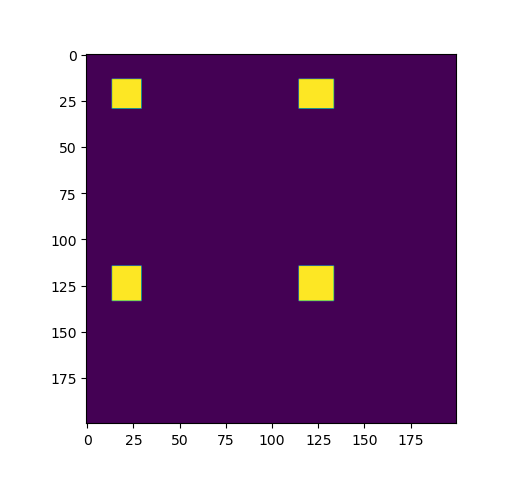

In [2]:
from neuroginius.synthetic_data.generation import generate_topology, generate_topology_net_interaction
from neuroginius.atlas import Atlas


refnet = "SomMot"
interaction = "SomMot"
atlas = Atlas.from_name("schaefer200")

topology = generate_topology(refnet, atlas.macro_labels)
topology += generate_topology_net_interaction((refnet, interaction), atlas.macro_labels)
networks = np.unique(atlas.macro_labels)

#for network in networks:
#    new = generate_topology_net_interaction((refnet, network), atlas.macro_labels)
#    topology += new

topology = np.where(topology != 0, 1, 0)
plt.imshow(topology)
plt.show()

In [3]:
ATLAS = "schaefer200"
k = 3

import os
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(config["output_dir"], k=k, feat="fc", atlas=ATLAS, groupkfold=True, net=refnet, inter=interaction)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 8 subjects because of lacking MMMSE


In [4]:
# Set non default to 0, transform to vec, and extract non zero coefficients
matrices *= topology

X = []
for mat in matrices:
    vec = sym_matrix_to_vec(mat, discard_diagonal=True)
    vec_idx = np.flatnonzero(vec) # Should only be computed once
    X.append(vec[vec_idx])

X = np.stack(X)
y = metadata.cluster_label
assert len(X) == len(y)

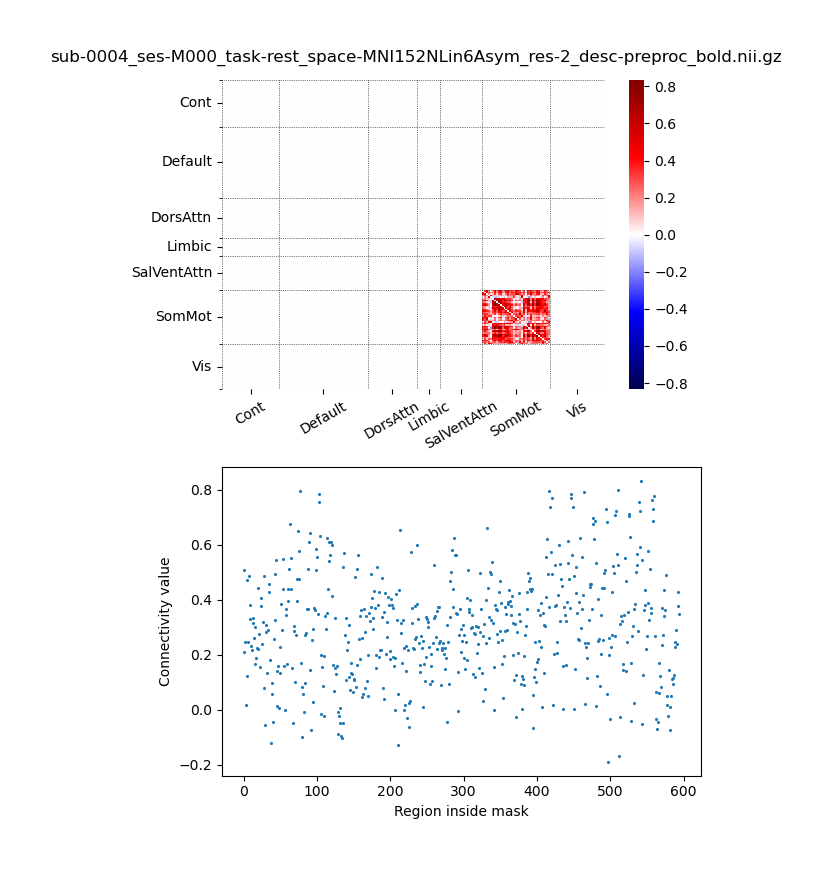

In [5]:
i = 2
row = metadata.iloc[i]
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

plot_matrix(matrices[i], atlas, axes=ax[0])

ax[1].scatter(np.arange(X.shape[1]), X[i], s=5)
ax[1].set_xlabel("Region inside mask")
ax[1].set_ylabel("Connectivity value")

fig.suptitle(f"{row.file_basename}")
fig.tight_layout()
plt.show()

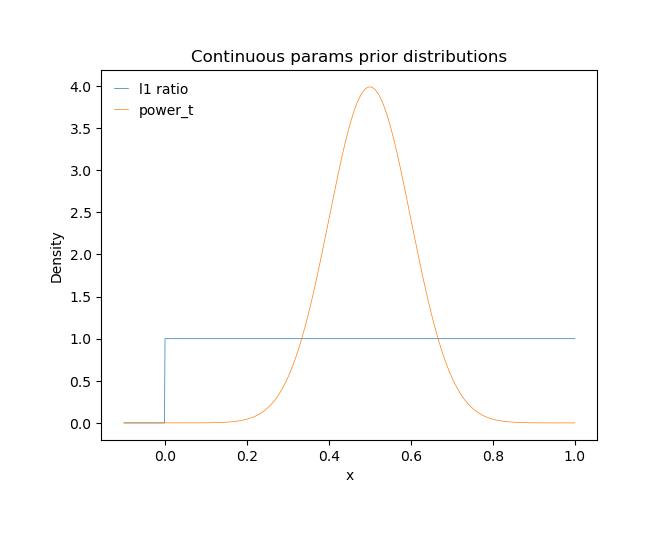

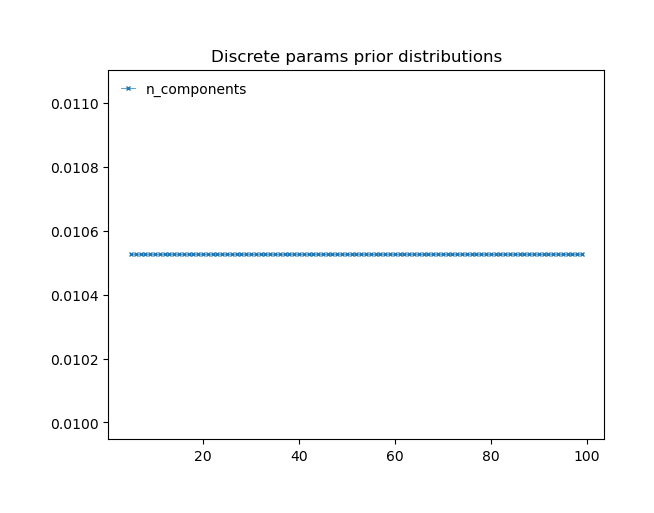

In [6]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


#plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

n_features = X.shape[1]
n_comps = list(range(5, 100))
dc = np.ones((len(n_comps))) * 1 / len(n_comps)
plt.plot(n_comps, dc, label="n_components", marker="x")
plt.title("Discrete params prior distributions")

plt.legend()
plt.show()

In [7]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
    #"reduction__n_components": n_comps
}

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, cross_val_score, StratifiedGroupKFold
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("scaler", preprocessing.StandardScaler()),
    #("reduction", PCA()),
    ("classifier", sgd)
    ],
    verbose=False
)

#inner_cv = GroupShuffleSplit(n_splits=8, random_state=1999).split(X, y, groups=metadata.CEN_ANOM.values)
inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)


search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [9]:
search.fit(X, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
43,0.748704,0.130420,0.003972,0.000537,0.001252,0.348610,modified_huber,0.591396,"{'classifier__alpha': 0.0012515100679043603, '...",0.378305,0.324786,0.338266,0.409238,0.309942,0.377295,0.380446,0.362116,0.360049,0.031023,1
47,0.723886,0.132208,0.004124,0.000809,0.001086,0.385242,modified_huber,0.660148,"{'classifier__alpha': 0.0010863427284506988, '...",0.433564,0.330818,0.306374,0.395901,0.300830,0.320490,0.363665,0.357211,0.351107,0.043125,2
86,0.739446,0.114409,0.003687,0.000726,0.000367,0.414635,modified_huber,0.672874,"{'classifier__alpha': 0.00036719188126644356, ...",0.408468,0.311966,0.354257,0.407847,0.298413,0.312994,0.351251,0.357219,0.350302,0.039232,3
72,0.772016,0.109707,0.004061,0.000768,0.000672,0.505781,modified_huber,0.604545,"{'classifier__alpha': 0.000672389473767877, 'c...",0.416967,0.311966,0.338266,0.378652,0.310000,0.324150,0.354766,0.360601,0.349421,0.034078,4
48,3.982013,1.697802,0.004048,0.001179,0.001958,0.901242,modified_huber,0.353756,"{'classifier__alpha': 0.0019579625386109203, '...",0.409773,0.330818,0.330808,0.328255,0.271044,0.313480,0.419374,0.391168,0.349340,0.048546,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.893213,0.131935,0.004248,0.000788,0.000216,0.845220,hinge,0.663156,"{'classifier__alpha': 0.00021594896801093995, ...",0.372911,0.316993,0.314363,0.387614,0.269542,0.318954,0.311836,0.343499,0.329464,0.035109,96
64,1.428935,0.259350,0.004416,0.001435,0.002516,0.732091,modified_huber,0.379546,"{'classifier__alpha': 0.0025163120035904822, '...",0.346897,0.243590,0.362685,0.350427,0.280000,0.323463,0.353114,0.375074,0.329406,0.042343,97
16,2.456734,0.771648,0.004823,0.000902,0.001778,0.860372,modified_huber,0.585357,"{'classifier__alpha': 0.0017782023716260693, '...",0.398926,0.251572,0.338540,0.344984,0.270476,0.309077,0.351654,0.354014,0.327406,0.044961,98
65,1.188472,0.227397,0.003836,0.000671,0.004597,0.586220,modified_huber,0.557856,"{'classifier__alpha': 0.004597037393299792, 'c...",0.351313,0.251572,0.346253,0.345234,0.298988,0.321387,0.339843,0.362137,0.327091,0.033910,99


In [10]:
est = search.best_estimator_
reg = est.named_steps["classifier"]

In [11]:
def net_select(label):
    if label == refnet:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network == refnet:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

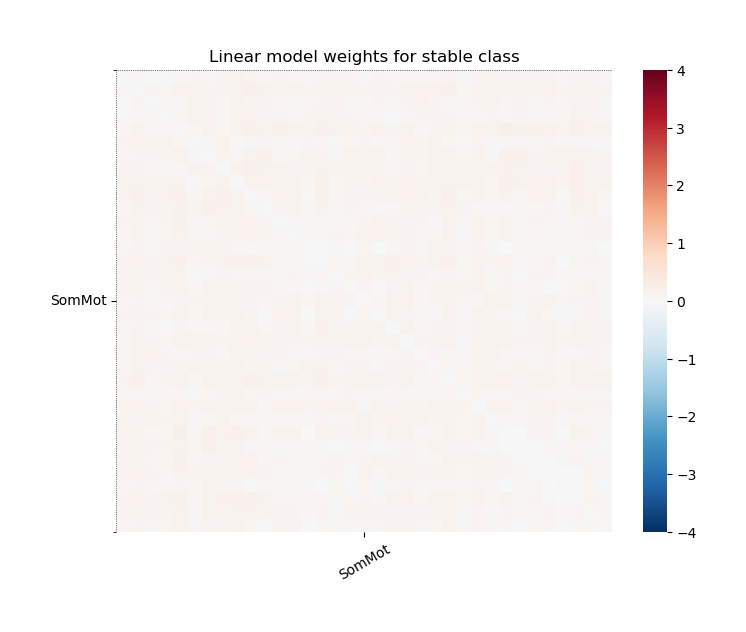

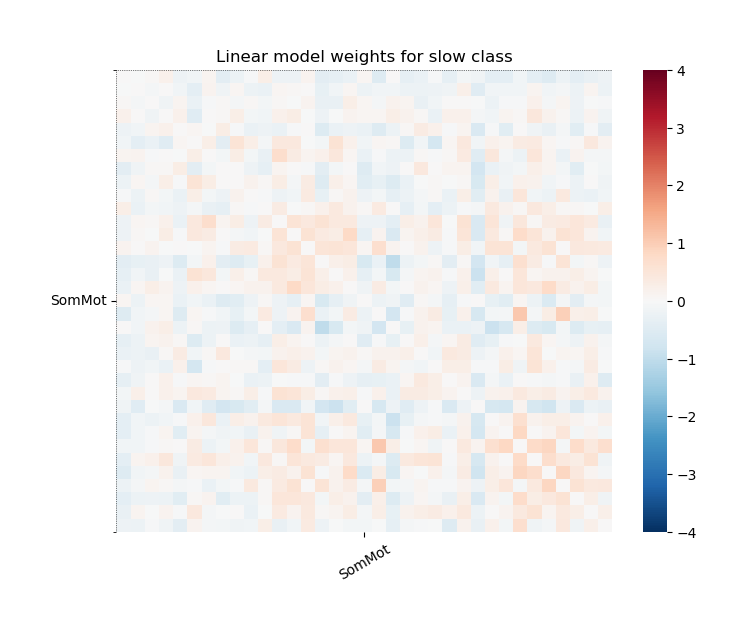

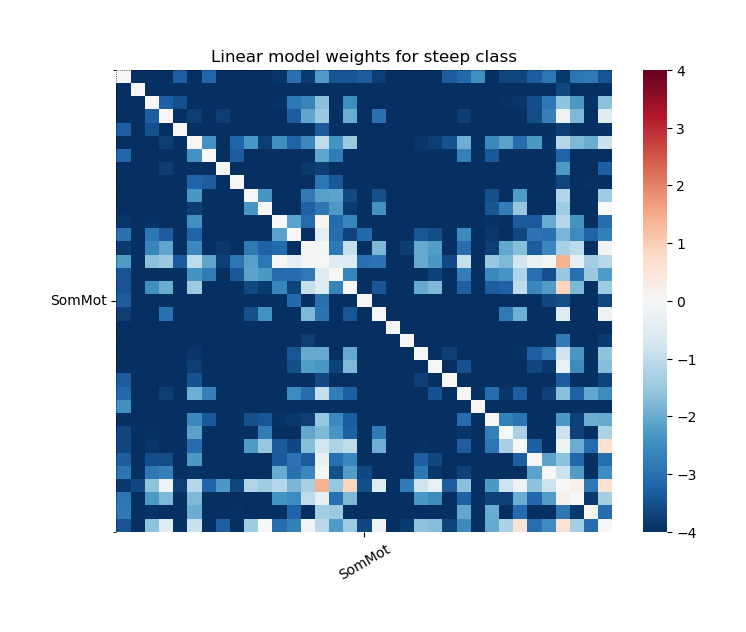

In [12]:
from nilearn.connectome import vec_to_sym_matrix
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    macro_labels = list(map(region_split, regions))
    
cats = ("stable", "slow", "steep")
for i in range(k):
    coefs = reg.coef_[i, :]
    # Perform Hauf transform to interpret coeffecients
    arr = vec_to_sym_matrix(np.cov(X.T) @ coefs, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        bounds=(-4, 4)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

In [13]:
test_scores = cross_val_score(
    search,
    X,
    y,
    cv=outer_cv.split(X, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    fit_params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


In [ ]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")
joblib.dump(topology, run_path / "topology.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Limbic_inter-SomMot/topology.joblib']